In [1]:
import pandahouse 
import pandas as pd
import scipy.stats as stats 
from scipy.stats import norm, ttest_ind
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import hashlib # Делать хеши
import swifter # Для ускорения метода apply
from tqdm import tqdm # Для отслеживания прогресса

In [2]:
#создаём генератор псевдослучайных чисел
rng = np.random.default_rng()

<b>Задача

<b>К нам пришли наши коллеги из ML-отдела и рассказали, что планируют выкатывать новый алгоритм, рекомендующий нашим пользователям интересные посты. После обсуждений того, как он это делает, можно сделать следующие выводы:

<b>1.Алгоритм добавляет пользователям 1-2 просмотра
    
<b>2.Вероятность того, что он сработает, составляет 90%
    
<b>3.Если у пользователя меньше 50 просмотров, то алгоритм не сработает

Гипотеза: увеличение числа просмотров (views) приведёт и к увеличению лайков (likes) на пользователя. 

Можем ли мы обнаружить различия в среднем количестве лайков на пользователя? 
Для этого необходимо провести симуляцию Монте-Карло.

- Распределения, из которых мы будем симулировать просмотры и пользовательские CTR, мы построим на основе периода АА-теста (c '2025-03-21' по '2025-03-27'), когда новый алгоритм еще не применялся. Это исторические данные.

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250520'
}

<b>Определяем базовые исторические уровни метрик - просмотров views и CTR - и их p-распределение

<b>Распределение просмотров

In [4]:
#Просмотры views на 1 пользователя в течение недели

q = """
SELECT views, count() as users
FROM
(SELECT  
    user_id,
    sum(action = 'view') as views
FROM {db}.feed_actions
WHERE toDate(time) between '2025-05-02' AND '2025-05-08'
GROUP BY user_id
)
GROUP BY views
"""

views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
views_distribution.head()

,views,users
0,198,24
1,116,171
2,294,1
3,66,393
4,272,4


In [6]:
#общее количество пользователей
views_distribution.users.sum()

49814

In [7]:
#нормируем на общее число всех пользователей, получаем вероятность этого значения
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [8]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
119,14,637,0.012788
59,16,616,0.012366
52,15,606,0.012165
137,33,602,0.012085
199,34,597,0.011985
...,...,...,...
198,282,1,0.000020
203,326,1,0.000020
245,336,1,0.000020
248,277,1,0.000020


In [9]:
sum_p = views_distribution['p'].sum()
print(f"Сумма вероятностей p: {sum_p}")

Сумма вероятностей p: 1.0


In [10]:
#Наше настоящее распределение просмотров (до применения алгоритма) сделаем дискретным.
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [11]:
views_distr

In [12]:
#cреднее число просмотров = 70
views_distr.mean()

67.11753723852732

In [13]:
#среднее число просмотров по сгенерированной выборке при размере 100 = 75 - выше, при 1000 - 71,8 - уже лучше
views_distr.rvs(size = 1000).mean() 

65.492

In [14]:
#медиана просмотров = 60
views_distr.median()

57.0

In [15]:
#стандартное отклонение = 46,8
views_distr.std()

45.637087804362665

<Axes: ylabel='Count'>

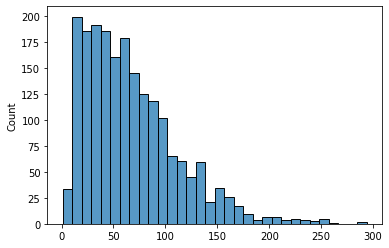

In [16]:
#Построим гистограмму просмотров
sns.histplot(views_distr.rvs(size=2000))

У нас есть ограничение по количеству просмотров, когда новый алгоритм не будет работать - 50 просмотров. Судя по гистограмме, под ограничение попадает большое число пользователей (максимальные частоты сосредоточены на малых значениях просмотров).

<b>Распределение CTR

In [17]:
#CTR за неделю

q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where dt between '2025-05-02' AND '2025-05-08'
group by dt, exp_group, user_id
)
group by ctr
"""
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [18]:
has_inf = np.isinf(ctr_distribution['ctr']).any()
print(f"Есть ли бесконечные значения (inf): {has_inf}")

Есть ли бесконечные значения (inf): True


In [19]:
ctr_distribution['users']

0     2033
1        5
2       29
3        9
4      111
      ... 
86     156
87    3789
88     438
89      92
90    2959
Name: users, Length: 91, dtype: uint64

In [20]:
ctr_distribution.users.sum()

96338

In [21]:
#нормируем на общее число всех пользователей - получаем вероятность этого значения
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [22]:
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
21,0.20,4977,0.051662
57,0.25,4298,0.044614
39,0.16,4111,0.042673
6,0.18,4015,0.041676
83,0.21,3799,0.039434
...,...,...,...
69,0.74,1,0.000010
9,0.91,1,0.000010
58,0.95,1,0.000010
47,0.87,1,0.000010


In [23]:
ctr_distribution['p']

0     0.021103
1     0.000052
2     0.000301
3     0.000093
4     0.001152
        ...   
86    0.001619
87    0.039330
88    0.004546
89    0.000955
90    0.030715
Name: p, Length: 91, dtype: float64

In [24]:
sum_p = ctr_distribution['p'].sum()
print(f"Сумма вероятностей p: {sum_p}")

Сумма вероятностей p: 1.0


In [25]:
#Наше настоящее распределение CTR до применения алгоритма сделаем дискретным
ctr_distr = stats.rv_discrete(name='ctr_distr', 
                                values=(ctr_distribution['ctr'], 
                                        ctr_distribution['p']))

<Axes: ylabel='Count'>

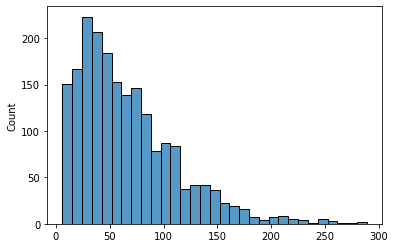

In [26]:
sns.histplot(views_distr.rvs(size=2000))

In [27]:
views_distr.mean() 

67.11753723852732

<b>- На эксперимент нам выделили неделю. Допустим, что за эту неделю в наш сервис зайдёт столько же пользователей, сколько зашло в период АА-теста (c 2025-03-21 по 2025-03-27). 
Мы планируем разбивать пользователей на две группы в соотношении 50/50. 
Посчитайте, сколько пользователей в таком случае придётся на одну группу.

In [28]:
#Посмотрим число пользователей за неделю (время AA-теста)
q = """
SELECT  
    count(distinct(user_id)) 
FROM {db}.feed_actions
WHERE toDate(time) between '2025-05-02' AND '2025-05-15'
"""

num_users = pandahouse.read_clickhouse(q, connection=connection)

In [29]:
num_users

,uniqExact(user_id)
0,72335


Количество пользователей в группе при разбивании на две в соотношении 50/50:

In [30]:
#размер группы должен быть равен:
num_group = round((num_users/2), 0)
num_group

,uniqExact(user_id)
0,36168.0


Сгенерируем две группы A и B для просмотров и CTR, а также лайков

<b>- Эффект применения нового алгоритма на просмотры мы симитируем следующим образом, соберем из таких частей: 
1) исходная сгенерированная выборка group_B_views + 
2) добавим увеличение на 1-2 просмотра: + ((1 + rng.binomial(n=1, p=0.5, size=размер_выборки)) 
3) учтем p=0.9 - вероятность 90%: * rng.binomial(n=1, p=0.9, size=размер_выборки) 
4) учтем ограничение, что алгоритм сработает только при более 50 просмотрах: * (group_B_views >= 50))  



Получаем:

group_B_views = group_B_views(исходная) + ((1 + rng.binomial(n=1, p=0.5, size=20998) * rng.binomial(n=1, p=0.9, size=20998) * (group_B_views >= 50))

для likes - симуляции биномиального распределения через двухмерный массив
rng.binomial(n, p, size=(количество_симуляций, размер_выборки))

- Количество симуляций задаем 20000

- Лайки мы будем сравнивать t-тестом с поправкой Уэлча на неравные дисперсии (equal_var=False). Уровень значимости по классике поставим 0.05.

In [31]:
# Гарантируем корректность данных
ctr_distribution['ctr'] = np.clip(ctr_distribution['ctr'], 0, 1)
ctr_distribution = ctr_distribution[ctr_distribution['p'] > 0]
ctr_distribution['p'] = ctr_distribution['p'] / ctr_distribution['p'].sum()
num_simulations = 20000
num_group = 36168
p_values = [] #все значения
for _ in tqdm(range(num_simulations)):
    group_A_views = rng.choice(views_distribution['views'], size=num_group, replace=True, p=views_distribution['p']).astype(np.int64)
    group_B_views = rng.choice(views_distribution['views'], size=num_group, replace=True, p=views_distribution['p']).astype(np.int64)
    group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=num_group) * (1 + rng.binomial(n=1, p=0.5, size=num_group)) *  (group_B_views >= 30))
    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=num_group, replace=True, p=ctr_distribution['p'])
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=num_group, replace=True, p=ctr_distribution['p'])
    
    # Дополнительная проверка (на всякий случай)
    assert np.all(group_A_ctr >= 0) and np.all(group_A_ctr <= 1), "Некорректные значения CTR в группе A"
    assert np.all(group_B_ctr >= 0) and np.all(group_B_ctr <= 1), "Некорректные значения CTR в группе B"
    
    group_A_likes = rng.binomial(group_A_views, group_A_ctr)
    group_B_likes = rng.binomial(group_B_views, group_B_ctr)
    p_values.append(stats.ttest_ind(group_A_likes, group_B_likes, equal_var=False).pvalue)

100%|██████████| 20000/20000 [08:50<00:00, 37.69it/s]


In [32]:
mask_a = group_A_views >= 30
mask_b = group_B_views >= 30
# Расчет мощности (доля p-value < 0.05)
power = (np.array(p_values) < 0.05).mean()
print(f"Мощность теста после фильтрации: {power:.2%}")

# Размеры выборок после фильтрации (средние по симуляциям)
avg_size_A = np.mean([np.sum(mask_a) for _ in range(num_simulations)])
avg_size_B = np.mean([np.sum(mask_b) for _ in range(num_simulations)])
print(f"Средний размер группы A после фильтрации: {avg_size_A:.0f}")
print(f"Средний размер группы B после фильтрации: {avg_size_B:.0f}")

Мощность теста после фильтрации: 59.57%
Средний размер группы A после фильтрации: 28147
Средний размер группы B после фильтрации: 28221


In [33]:
p_values[0:5]

[0.03745408796741274,
 0.09765844326468412,
 0.04474933443874946,
 0.26923380963974824,
 0.0014121863624109027]

In [34]:
#мощность теста
round((np.mean(np.array(p_values) < 0.05)*100), 1)

59.6

мощность теста - это вероятность того, что статистический тест правильно отвергнет нулевую гипотезу (H₀), когда она на самом деле ложная. Иными словами, мощность теста показывает, насколько тест эффективен в выявлении реальных эффектов или различий, если они существуют.